In [1]:
data_dir = '/home/addy/datasets/rakhmanov_mapt/'

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk(data_dir):
    print(dirname)

/home/addy/datasets/rakhmanov_mapt/
/home/addy/datasets/rakhmanov_mapt/8
/home/addy/datasets/rakhmanov_mapt/7
/home/addy/datasets/rakhmanov_mapt/4
/home/addy/datasets/rakhmanov_mapt/10
/home/addy/datasets/rakhmanov_mapt/5
/home/addy/datasets/rakhmanov_mapt/11
/home/addy/datasets/rakhmanov_mapt/6
/home/addy/datasets/rakhmanov_mapt/9


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchvision
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

plt.style.use('dark_background')

print(f"{'Pytorch':<20}",torch.__version__)
if torch.cuda.is_available():
    device='cuda'

    print(f"{'Device':<20}", f"GPU ({torch.cuda.get_device_name(0)})")
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'


Pytorch              1.10.2+cu102
Device               GPU (NVIDIA GeForce GTX 1660 Ti)


In [3]:
seed = 133
img_size = 256

batch_size = 16

In [58]:
transform_image = torchvision.transforms.Compose([
    # torchvision.transforms.CenterCrop([256, 450]),
    torchvision.transforms.Resize([img_size, img_size]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_label = lambda x: torch.tensor(float(x)).unsqueeze(-1)

dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=transform_image,
    target_transform=transform_label
)

len_train = int(len(dataset) * 0.8)
len_test = len(dataset) - len_train

#using random_split from torch.utils.data 
train_dataset, test_dataset = random_split(
    dataset, [len_train, len_test], 
    generator=torch.Generator().manual_seed(seed)    )

print("Images in the train set:",len(train_dataset))
print("Images in the test set:",len(test_dataset))

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    prefetch_factor=3)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=12,
    prefetch_factor=3)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y [N, 1]:", y.shape)
    break

Images in the train set: 761
Images in the test set: 191
Shape of X [N, C, H, W]:  torch.Size([16, 3, 256, 256])
Shape of y [N, 1]: torch.Size([16, 1])


In [59]:
class_names = dataset.classes
class_names

['10', '11', '4', '5', '6', '7', '8', '9']

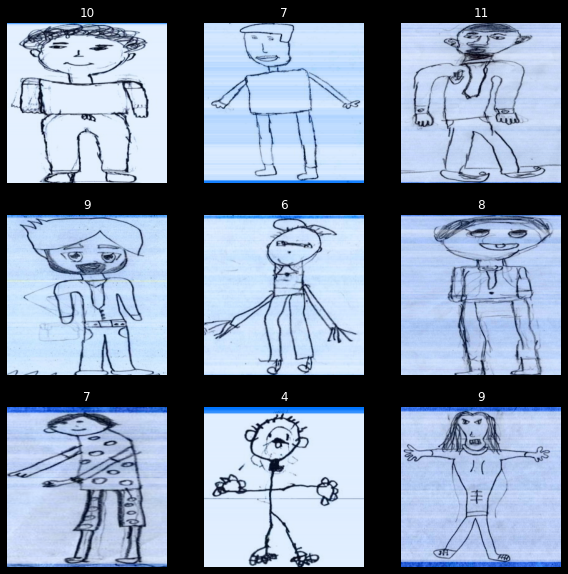

In [60]:
class_names = list(train_dataset.dataset.class_to_idx.keys())

fig = plt.figure(figsize=(10, 10))
for images, labels in train_dataloader:
    for i in range(min(batch_size, 9)):        
        ax = plt.subplot(3, 3, i + 1)
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        
        img -= img.min(axis=(1,2), keepdims=True)
        img /= img.max(axis=(1,2), keepdims=True)
        
        plt.imshow(img)
        plt.title(class_names[int(labels[i].item())])
        plt.axis("off")
    break
        

plt.show()


In [77]:
import torch.nn as nn
import torch.nn.functional as F


class NNet(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(57600, 128) # 64 * 81 * 4
        self.fc2 = nn.Linear(128, N)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader.dataset)
    loss_sum, accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    loss_sum /= size
    history['train_loss'].append(loss_sum)
    history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0
    ys = []
    preds = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            ys.append(y)
            
            pred = model(X)

            preds.append(pred)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    ys = torch.cat(ys) 
    preds = torch.cat(preds) 
    
    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy, (ys, preds)


In [78]:

choices = np.array([int(i) for i in range(len(dataset.classes))])
choice_first = choices.min()
counts = np.array([0] * len(choices))
for batch, (X, y) in enumerate(train_dataloader):
    for i in y:
        if i>max(choices) or i<0:
            print(i)
        counts[int(i)] += 1
p = counts/np.sum(counts)
p

array([0.08015769, 0.04204993, 0.14717477, 0.13929041, 0.16425756,
       0.17739816, 0.11169514, 0.13797635])

In [79]:
from numpy.random import choice
    
size = len(test_dataloader.dataset)
accuracy = 0
for X, y in test_dataloader:
    # y_pred = choice(choices, len(y) ,
    #           p=p).astype(float)
    # y_pred = np.expand_dims(y_pred, axis=-1)
    
    y_pred = np.ones(y.shape)*6
    y_pred = torch.from_numpy(y_pred)
    accuracy += (torch.round(y_pred) == y).type(torch.float).sum().item()
accuracy /= size
accuracy

0.2094240837696335

In [80]:
# model = NNet(N=1).to(device)
model_ft = torchvision.models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 1)

model = model_ft.to(device)


    
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())


epochs = 30
history = {
    'train_loss':[],
    'train_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
    train_loop(train_dataloader, model, loss_fn, optimizer, history)
    _, _, cov = test_loop(test_dataloader, model, loss_fn, history)
    # break


03:20 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  6.67s/epoch]


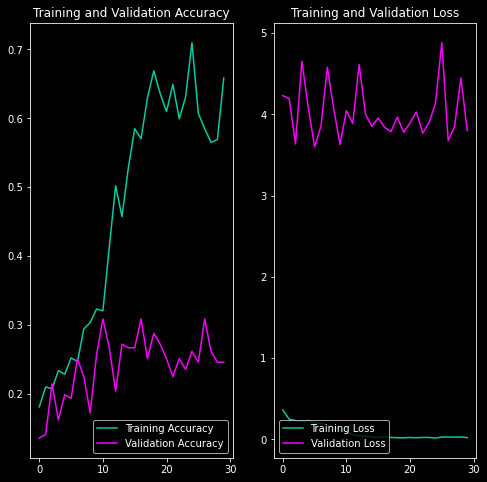

In [81]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='#03CEA4')
plt.plot(epochs_range, history['test_accuracy'], label='Validation Accuracy', color='#fc00ff')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='#03CEA4')
plt.plot(epochs_range, history['test_loss'], label='Validation Loss', color='#fc00ff')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()
